In [1]:
%matplotlib inline
import cv2
import torch
#from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [56]:
#torch.version
print(torch.__version__)

1.0.1.post2


In [ ]:
#пока пользуюсь numpy csv для извлечения. С даталоадером торча еще не разобрался

In [3]:
train = np.loadtxt('../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
train.shape

(42000, 785)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# пикселы - в другую 
train = train[:, 1:]
#test_img = test.shape[]

In [6]:
#отбираем единицы и двойки
one=np.where(train_label ==1)
two=np.where(train_label ==2)

In [7]:
len(two[0])

4177

In [8]:
train_label[np.where(train_label ==1)].shape

(4684,)

In [9]:
one_two_ind=np.concatenate((one, two), axis=1)[0]

In [10]:
one_two_ind

array([    0,     2,    12, ..., 41970, 41976, 41981])

In [11]:
#сокращаем весь датасет до двух цифр
train=train[one_two_ind]
y_train=train_label[one_two_ind]
y_train

array([1., 1., 1., ..., 2., 2., 2.])

## Разбиваем выборку на обучение и валидацию

In [12]:
from sklearn.model_selection import train_test_split


In [13]:
y_train, y_val, x_train, x_val = train_test_split(
    y_train, train, test_size=0.2, random_state=42)

## Попробую с бинаризацией. С ней и без нее отношения условных вероятностей уходят в бесконечность

In [14]:
x_train, x_val =np.sign(x_train), np.sign(x_val)

In [15]:
x_train=torch.tensor(x_train)
x_val=torch.tensor(x_val)

In [16]:
training_tensor_2 = torch.tensor(x_train[np.where(y_train==2)])
training_tensor_1 = torch.tensor(x_train[np.where(y_train==1)])

/home/zamarseny/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/home/zamarseny/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [17]:
r=training_tensor_2.reshape(-1,28,28).mean(dim=0)
g=training_tensor_1.reshape(-1,28,28).mean(dim=0)
b=np.zeros(g.shape)
img2=np.concatenate((r, g), axis=0)
#img=np.stack((r, g, b), axis=0)
img=np.stack((r, g, b), axis=2)

(28, 28, 3) torch.Size([28, 28])


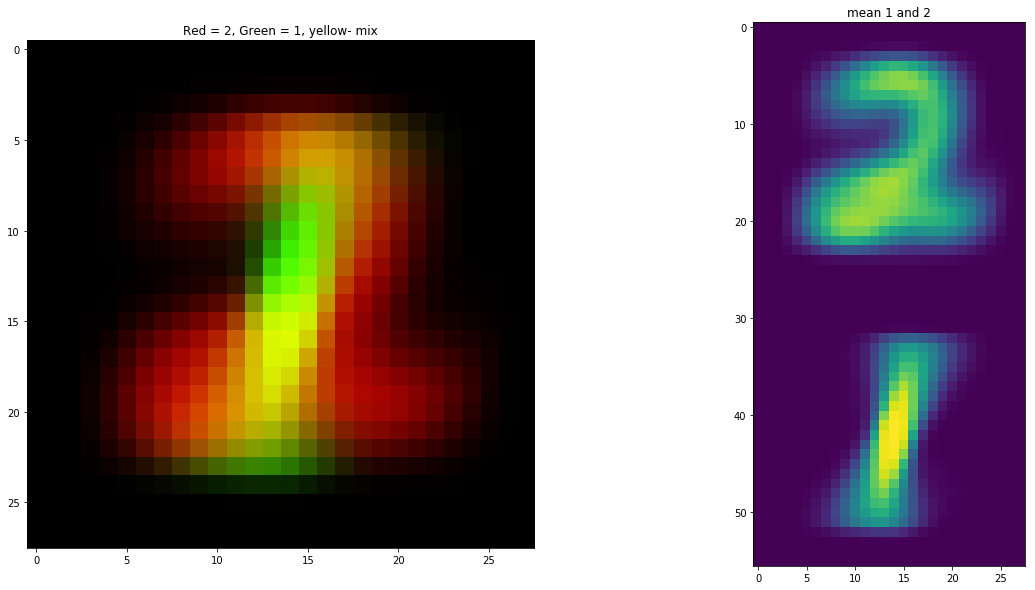

In [18]:
print(img.shape, r.shape)
#plt.imshow(img, cmap='gray');
#plt.imshow(img)
#plt.imshow(img2);

fig = plt.figure(figsize=(20, 10))
subplot = fig.add_subplot(1, 2, 1)
plt.imshow(img);
subplot.set_title('Red = 2, Green = 1, yellow- mix');
subplot = fig.add_subplot(1, 2, 2)
plt.imshow(img2);
subplot.set_title('mean 1 and 2');

In [46]:
#очень хорошо видно какие пикселы увеличат вероятность двойки (красные по бокам), 
#какие единицы (зеленые в центре)

In [19]:
r.shape, g.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

In [20]:
training_tensor_2.shape

torch.Size([3352, 784])

In [ ]:
#вычисляю условные вероятности зажигания пикселей при выпадении 1 или 2

In [21]:
p_pix_2 = training_tensor_2.sum(dim=0) / training_tensor_2.sum()
p_pix_1 = training_tensor_1.sum(dim=0) / training_tensor_1.sum()

In [24]:
#p_pix_2#.shape

In [25]:
#вероятности классов
p_2 = ((y_train == 2)*1).sum() / len(y_train)
p_1 = ((y_train == 1)*1).sum() / len(y_train)

In [26]:
p_2, p_1

(0.4729119638826185, 0.5270880361173815)

In [ ]:
#((y_train == 2)*1).sum()

In [27]:
#b=0.001 #{Хотел добавить смещение, но и без него работает}
#вероятность класса "2" при выпадении х на трэйне
p_2_x=torch.zeros(x_train.shape[0])
for i in range(len(x_train)):
    #p_2_x_i_div_by_p_1_x_i=((x_train[i]*p_pix_2)[np.where(x_train[i] >0)]\
    #/(x_train[i]*p_pix_1)[np.where(x_train[i] >0)]+b)\
    #.log().sum()
    #p_2_x[i]=p_2_x_i.item()
    
    ln_p_2_x_i_div_by_p_1_x_i=np.log(p_2/p_1)+((x_train[i]*p_pix_2)[np.where(x_train[i] >0)]\
    /(x_train[i]*p_pix_1)[np.where(x_train[i] >0)])\
    .log().sum()
    
    #ln_p_2_x_i_div_by_p_1_x_i=np.log(p_2/p_1)+((x_train[i]*p_pix_2)\
    #/(x_train[i]*p_pix_1))\
    #.log().sum()

    p_2_x[i]=ln_p_2_x_i_div_by_p_1_x_i.item()

In [29]:
#то же самое для теста
p_2_x_test=torch.zeros(x_val.shape[0])
for i in range(len(x_val)):
    ln_p_2_x_i_div_by_p_1_x_i=np.log(p_2/p_1)+((x_val[i]*p_pix_2)[np.where(x_val[i] >0)]\
    /(x_val[i]*p_pix_1)[np.where(x_val[i] >0)])\
    .log().sum()
    p_2_x_test[i]=ln_p_2_x_i_div_by_p_1_x_i.item()

In [30]:
#np.where(y_train == 2)
#x_train[i].shape,p_pix_2.shape
#len(p_2_x), len(y_train), i, np.log(p_2/p_1)
len(p_2_x[np.where(abs(p_2_x)<600)])

5928

In [32]:
#многие отношения вероятностей ушли в плюс/минус бесконечность

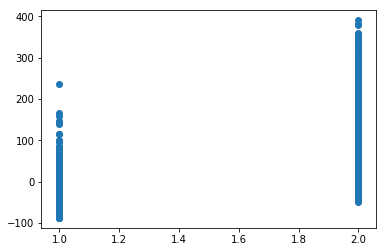

In [33]:
plt.scatter(y_train, p_2_x)

(array([2964.,  726.,  331.,  444.,  554.,  481.,  268.,  114.,   37.,
           9.]),
 array([-88.02883 , -40.174213,   7.680402,  55.53502 , 103.38963 ,
        151.24425 , 199.09886 , 246.95349 , 294.8081  , 342.66272 ,
        390.51733 ], dtype=float32),
 <a list of 10 Patch objects>)

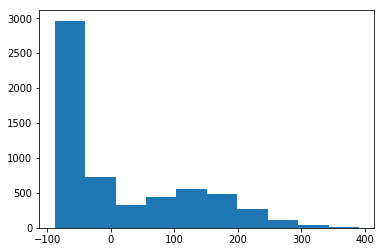

In [34]:
plt.hist(p_2_x[np.where(abs(p_2_x)!=np.inf)])

In [ ]:
#большая часть (от неушедших в бесконесчность) отношений лежит в диапазоне (-100,0)

In [36]:
#предсказание классификатора для трэйна. b - пороговое значение
b=0
y_pred=np.zeros(y_train.shape)
y_pred[np.where(p_2_x<b)]=1
y_pred[np.where(p_2_x>=b)]=2

In [37]:
y_pred_val=np.zeros(y_val.shape)
y_pred_val[np.where(p_2_x_test<b)]=1
y_pred_val[np.where(p_2_x_test>b)]=2

(array([3736.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3352.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

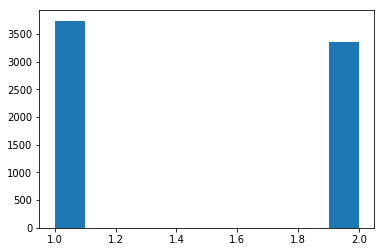

In [38]:
#plt.hist(y_pred)
plt.hist(y_train)

In [39]:
#считаем точность на трэйне и смотрим индексы неверно классифицированных цифр
correct=0
incorr_ind=[]
nmb=0
for i in zip(y_pred, y_train):
        if i[1]==i[0]:
            correct+=1
        else:
            incorr_ind.append(nmb)
        nmb+=1
        #print(i[1])
print('train_accuracy=', correct/len(y_train))


train_accuracy= 0.9712189616252822


In [40]:
#аналогично для теста
correct=0
incorr_ind=[]
nmb=0
for i in zip(y_pred_val, y_val):
        if i[1]==i[0]:
            correct+=1
        else:
            incorr_ind.append(nmb)
        nmb+=1
        #print(i[1])
print('test_accuracy=', correct/len(y_val))


test_accuracy= 0.9678510998307953


In [42]:
#удивительно, что наугад выбранное смещение =0 дало такую точность

In [43]:
len(incorr_ind)
#y_pred[incorr_ind], y_train[incorr_ind]

57

## Визуализируем ошибки классификатора

In [44]:
y_pred_val_wrong=y_pred_val[incorr_ind]
x_val_wrong=x_val[incorr_ind].resize(x_val[incorr_ind].shape[0],28,28)
x_val_wrong.shape, y_pred_val_wrong.shape

/home/zamarseny/anaconda3/envs/nlp/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(torch.Size([57, 28, 28]), (57,))

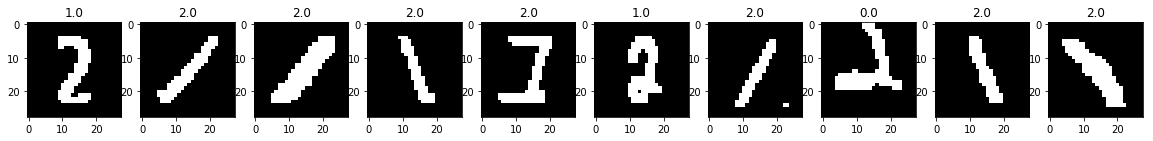

In [45]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(x_val_wrong[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_pred_val_wrong[i - 1]);

In [ ]:
# видно, что неправильно классифицируются сильно наклоненные единицы и слишком тонкие двойки

In [ ]:
#КОНЕЦ РЕШЕНИЯ

In [ ]:
#Just to be shure, that it can work - fit SKlearn Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_val)
print("Number of mislabeled points out of a total %d points : %d"
       % (x_val.shape[0], (y_val != y_pred).sum()))

In [ ]:
#y_pred, y_val
#len((y_pred==y_val)*1), sum(y_pred==y_val)

In [ ]:
print('Accuaracy=', sum(y_pred==y_val)/len(y_pred))

In [ ]:
wrong_=(y_pred!=y_val)
np.where(wrong_==True)

In [ ]:
wrong_class = np.resize(x_val[np.where(wrong_==True)], (x_val.shape[0], 28, 28))
wrong_label=y_pred[np.where(wrong_==True)]

In [ ]:
wrong_label

In [ ]:
$P(two|pixel)=\frac{P(pixel|two)P(two)}{P(pixel)}$

#$P(two|pixel)=\frac{P(pixel_1|two)P(pixel_2|two)...P(pixel_n|two)P(two)}{P(w_1)P(pixel_2)...P(pixel_n)}$